# Comparing bulk and single-cell survival probabilities

In [135]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, '../../')
import mscl.stats
import mscl.plotting
import scipy.spatial
import sklearn.metrics
import tqdm
colors = mscl.plotting.set_plotting_style()
%matplotlib inline

In [2]:
# Load the constants from the logistic regression.
stats = pd.read_csv('../../data/csv/complete_mcmc_stats.csv')

# Get the statistics only for the fast shock.
beta_0 = stats[stats['parameter'] == 'beta_0__0']['median'].values[0]
beta_1 = stats[stats['parameter'] == 'beta_1__0']['median'].values[0]

In [3]:
# Define a function for the survival probability
def surv_prob(chan, beta_0, beta_1):
    logit = beta_0 + beta_1 * np.log(chan)
    return (1 + np.exp(-logit))**-1

In [4]:
# Set some constants
n_sim = 10
chan_mu = 300
chan_sigma = 50
n_cells_microscopy = int(25)
dilution_factors = np.logspace(1, 6, 5)

##  Single-cell experiment

In [5]:
# Generate the distribution of cells.
cells = np.random.normal(loc=chan_mu, scale=chan_sigma, size=(n_sim, n_cells_microscopy))
    
# Determine the survival probability for each.
p_s = surv_prob(cells, beta_0, beta_1)
    
# Flip the coins and determine who survives.
flips = np.random.random(size=(n_sim, n_cells_microscopy)) <= p_s

# Determine those who survive.
survivors = cells * flips
n_survivors = np.sum(flips)
measured_surv_prob = np.sum(flips, axis=1) / n_cells_microscopy
measured_err = np.sqrt(n_survivors * (n_sim * n_cells_microscopy - n_survivors) / (n_sim * n_cells_microscopy)**3)

<Container object of 3 artists>

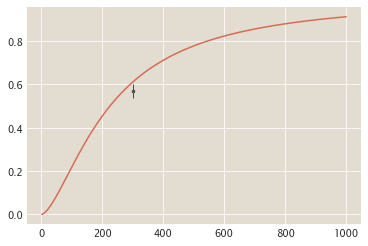

In [6]:
chan_range = np.logspace(0, 3, 500)
plt.plot(chan_range, surv_prob(chan_range, beta_0, beta_1), color=colors['red'])
plt.errorbar(chan_mu, np.mean(measured_surv_prob), measured_err, fmt='.', color='#4b4b4b', lw=1, ms=5, zorder=100)

##  Bulk experiment

In [146]:
# Make it bulk scale
n_cells_bulk = 3E8 # OD 0.3 in 1mL.
plate_size = int(3E5)
min_dist = 500

cell_counts = np.zeros((n_sim, len(dilution_factors)))
# Set up the "plates" assuming 1px is 1 cell, 4µm^2.
for i in tqdm.tqdm(range(n_sim)):
    for j, d in enumerate(dilution_factors):
        cntrl_plate = np.zeros((plate_size, plate_size))
        exp_plate = np.zeros((plate_size, plate_size))

        # Partition the coordinates, assuming all cells in the dilution 
        # factor make it on the plate.
        dilution = int(n_cells_bulk / d)
        coords = np.random.uniform(0, plate_size, size=(2, dilution)).astype(int)
        dist = np.sqrt(sklearn.metrics.pairwise.pairwise_distances(coords.T))
        cell_counts[i, j] = np.sum(dist)
        


  0%|          | 0/10 [00:00<?, ?it/s]


MemoryError: 

In [147]:
kcoords.T


array([[ 20027,  42518],
       [ 59609,  51810],
       [256350, 114172],
       ...,
       [211543, 296226],
       [ 92640, 267760],
       [ 53343, 123727]])

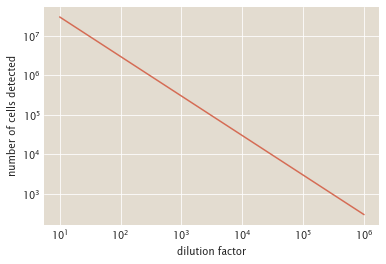

In [96]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('dilution factor')
ax.set_ylabel('number of cells detected')
_ = ax.plot(dilution_factors, n_cells_bulk / dilution_factors, color=colors['red'])


In [48]:
b

array([143650, 285155, 209521, 241884,   6096,   2603, 246722, 157576,
       145321, 220596])